In [1]:
import earthchem
earthchem.__version__

'0.0.3+4.gc916316.dirty'

Make a rest client

In [2]:
q = earthchem.Query(author='klump')
q.url

'http://ecp.iedadata.org/restsearchservice?outputtype=json&author=klump'

How many records have we found?

In [3]:
q.count()

0

In [4]:
q.dataframe()

Didn't find any records for this query, returning None


Let's try another author

In [5]:
q = earthchem.Query(author='barnes')
q.count()

4902

Get the first 50 records

In [6]:
%pdb
df = q.dataframe()

Automatic pdb calling has been turned ON


In [7]:
%matplotlib inline

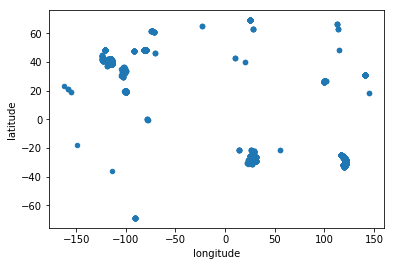

In [8]:
df.plot('longitude', 'latitude', 'scatter')

Lets try and paginate this instead

In [9]:
q['searchtype'] = 'rowdata'
q['standarditems'] = 'yes'

In [10]:
q.count()

4902

In [18]:
items_per_page = 50
max_items = q.count()

In [1]:
import earthchem
from earthchem.pagination import make_pages

In [5]:
import tqdm
import requests
import pandas

from io import StringIO

In [6]:
self = earthchem.Query(author='barnes')
max_items = 124

In [7]:

# Get the list of pages we're going to use, use to set up tqdm and query
pages = make_pages(max_items or self.count())[:4]
tqdm_kwargs = {
    'desc': 'Downloading pages',
    'total': len(pages)
}

# Set basic search params
self['searchtype'] = 'rowdata'
self['standarditems'] = 'yes'

# Accumulate pages as we go
accumulator = None
for page in tqdm.tqdm(pages, **tqdm_kwargs):
    self['startrow'], self['endrow'] = page
    resp = requests.get(self.url)
    if resp.ok:
        # Create a new dataframe to add to the old one
        df = pandas.read_json(StringIO(resp.text))
        if accumulator is None:
            accumulator = df
        else:
            accumulator = pandas.concat([accumulator, df])

In [10]:
len(accumulator)

125

Now we can generate a plot of this data

In [ ]:
%matplotlib inline

df.plot('longitude', 'latitude', 'scatter')

In [ ]:
df.plot('al2o3', 'mgo', 'scatter')